<a href="https://colab.research.google.com/github/trevorVlong/underactuated/blob/main/learning_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamics Regression and Graphical Analysis


## Notebook Setup 
The following cell will checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [ ]:
import importlib
import os, sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='1dca1b915977aeec9f327d61aaeac4cfb9c6b408', drake_version='0.25.0', drake_build='releases')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

# python libraries
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# underactuated imports
from underactuated import plot_2d_phase_portrait

## Problem Description
In this problem you will implement a simple neural network in pytorch to model the dynamics of the damped pendulum seen in class from data. At the end of the notebook, you will perform a graphical analysis and answer a few questions about the system.

**These are the main steps of the exercise:**
1. Implement the network architecture in pytorch
2. Perform a graphical analysis of the dynamics

## Sampling measurements
In class, we derived the dynamics for the damped pendulum system analytically:

> $b\dot\theta = u_0 - mgl\sin\theta$

In this problem, we pretend we don't know the relationship $\dot \theta = f(\theta)$ and would like to learn it from $(\theta, \dot \theta)$ data measurements. That is, we'd like to train a neural network $NN(\theta) \approx f(\theta) = \dot \theta$.

In the cell below, we assume a pendulum with $l = 1$ and $m = 1$ for simplicity. Gravity is $g = 9.81$, and we assume 0 torque. We generate 10000 evenly spaced samples from the ground truth equations, and then sample 100 examples and add some random noise to "simulate" taking 100 measurements. The data we're trying to fit is plotted below.


### Pytorch tip

One tip you'll find useful when debugging is to fix the random seed generators for your machine learning library (in our case pytorch), and potentially for numpy as well. This allows us to ensure that our neural network will be initialized with the same values each time we run our code, and it will allow us to see the effects of our changes and make things easier to debug. We can fix the random generator seed as seen below.

Text(0, 0.5, 'theta_dot')

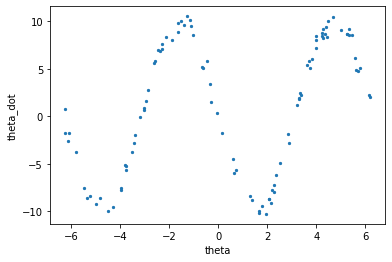

In [ ]:
np.random.seed(5) # you can pick any integer for different seeds
torch.manual_seed(5)

# System parameters. Feel free to play with these, but use
# the original set for the autograder!
m = 1
l = 1
g = 9.81
u = 0

def generate_measurements():
  # create ground truth data points
  theta = torch.unsqueeze(torch.linspace(-2*np.pi, 2*np.pi, 10000), dim=1)

  # subsample 100 ground truth data points and add noise
  idxs = np.random.choice(10000, 100)
  theta = theta[idxs]
  theta_dot = u - m*g*l*torch.sin(theta) + 1.5*torch.rand(theta.size()) - 1.5*torch.rand(theta.size())

  return theta, theta_dot

# plot sampled measurements
theta, theta_dot = generate_measurements()
plt.scatter(theta, theta_dot, s=5)
plt.xlabel('theta')
plt.ylabel('theta_dot')

## Defining our Network

We will now implement our neural network in pytorch. Pytorch allows us to define a model class as a subclass of `nn.Module` (checkout the [pytorch docs](https://pytorch.org/docs/stable/index.html) for more information). We define our network architecture at initialization, and then we define a `forward` method that defines our forward pass. This method takes in the inputs to our neural network, and returns the outputs. 

We've provided an example model that shows you how to stack two linear layers with a Leaky ReLU nonlinearity in between them. Your job is to define `self.model`.

- Layer 1: linear layer with 1 input and 200 outputs
- Leaky ReLU nonlinearity
- Layer 2: linear layer with 200 inputs and 100 outputs
- Leaky ReLU nonlinearity
- Layer 3: linear layer with 100 inputs and 1 output

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()

    # Example model
    self.example_model = nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )
    
    ####################################
    # Define your model

    self.model = nn.Sequential(
        torch.nn.Linear(1,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100,1)
    )
    
    ####################################

  def forward(self, theta):
    theta_dot_hat = self.model(theta)
    return theta_dot_hat

## Training our Network

Now we can instantiate a network, an optimizing algorithm that will update the weights of our network, and a loss function. We will be using a mean-squared error loss for this problem. We are going to use the following optimizer and loss function:

- Optimizer: [Adam optimizer](https://pytorch.org/docs/stable/optim.html)
- Loss function: [Mean-squared Error loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In the cell below, your job is to instantiate a mean-squared error loss, and an Adam optimizer.

We then iteratively update the parameters of our network. This is done by feeding in the theta values we measured, and computing a loss using the outputs (the networks "guess" for the theta dot outputs). If our predicted theta dots are far from the theta dots we measured, then our loss will be high and vice versa. We use the loss to call `loss.backward()`, pytorch runs [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) to update the network weights we passed into the Adam optimizer at initialization for us.

### Pytorch tip

Note that we zero out our gradients before we step through our optimizer at each iteration. We need to do this because pytorch accumulates gradients after each pass. This is used to train other types of networks like RNN's, but for our purposes here we want just the new gradients at each iteration.

In [ ]:
np.random.seed(5) # you can pick any integer for different seeds
torch.manual_seed(5)

# Feel free to play with these, but keep the original values for the autograder.
iterations = 1000 # number of optimization iterations
learning_rate = .05 # you do not need to tune this!

# Generate measurements
theta, theta_dot = generate_measurements()

# Initialize our network, optimizer, and loss function
NN = Network()

####################################
# Instantiate a mean-squared error loss
# and an Adam optimizer. You can access
# your networks parameters with NN.parameters().
# You will need to pass this in as an
# argument when instantiating the optimizer.

# YOUR CODE HERE
optimizer = torch.optim.Adam(NN.parameters())
L = torch.nn.MSELoss()

####################################

final_loss = 0.0
if optimizer is not None and L is not None:
  for t in range(iterations):

    theta_dot_hat = NN(theta) # pass data through your neural net, and generate x_ddot predictions

    loss = L(theta_dot_hat, theta_dot) # compare your predictions with the measured x_ddot values from your data set

    print('Loss @ time {}: {}'.format(t, loss.item()))

    optimizer.zero_grad() # clear gradients from the last iteration, before generating gradients for this iteration
    loss.backward() # run backpropagation, and compute gradients
    optimizer.step() # apply gradients to your network weights

  final_loss = loss.item()

Loss @ time 0: 48.07992172241211
Loss @ time 1: 45.680519104003906
Loss @ time 2: 43.8422966003418
Loss @ time 3: 42.37051773071289
Loss @ time 4: 41.235836029052734
Loss @ time 5: 40.38322067260742
Loss @ time 6: 39.70164489746094
Loss @ time 7: 39.133453369140625
Loss @ time 8: 38.6715087890625
Loss @ time 9: 38.29315948486328
Loss @ time 10: 37.976600646972656
Loss @ time 11: 37.7104377746582
Loss @ time 12: 37.493621826171875
Loss @ time 13: 37.292423248291016
Loss @ time 14: 37.07884216308594
Loss @ time 15: 36.843048095703125
Loss @ time 16: 36.566890716552734
Loss @ time 17: 36.25083541870117
Loss @ time 18: 35.90122985839844
Loss @ time 19: 35.529563903808594
Loss @ time 20: 35.147762298583984
Loss @ time 21: 34.767250061035156
Loss @ time 22: 34.394500732421875
Loss @ time 23: 34.033546447753906
Loss @ time 24: 33.68429946899414
Loss @ time 25: 33.34605407714844
Loss @ time 26: 33.01543045043945
Loss @ time 27: 32.688846588134766
Loss @ time 28: 32.36116027832031
Loss @ time 2

## Evaluating our Model

Now that we've trained our network, let's look at how well we did. To do this, we will feed in a range of theta values and see how well our networks predictions line up with the ground truth dynamics of our system. We plot the original data in blue, and our neural networks fit in red.

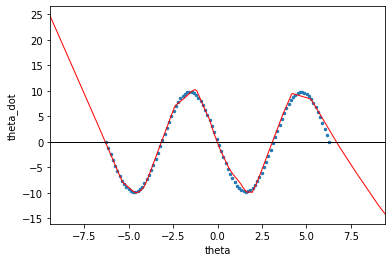

In [ ]:
if optimizer is not None and L is not None:
  theta_eval = torch.unsqueeze(torch.linspace(-3*np.pi, 3*np.pi, 10000), dim=1)
  theta_ground = np.linspace(-2*np.pi, 2*np.pi, 100)
  theta_dot_ground = u - m*g*l*np.sin(theta_ground)

  # NOTE: some layers like batchnorm or dropout layers need to be turned
  # off during evaluation and turned on during training. Calling model.eval()
  # will do this for you. We do not use these types of layers here, but we
  # call eval() here to demonstrate for potential future use. To go back to "training"
  # mode, call model.train()
  NN.eval()

  # evaluate our network
  theta_dot_eval = NN(theta_eval)

  # plot our fit
  plt.scatter(theta_ground, theta_dot_ground, s=6)
  plt.plot(theta_eval, theta_dot_eval.data.numpy(), color='red', lw=1) # this is how to convert a pytorch tensor to a numpy array
  plt.plot(np.linspace(-4*np.pi, 4*np.pi, 3), np.zeros(3), color='black', lw=1)
  plt.xlim(-3*np.pi, 3*np.pi)
  plt.xlabel('theta')
  plt.ylabel('theta_dot')

## Written questions

Answer these written exercises in a pdf (preferably latex) and upload it gradescope.

1) Within the range $\theta \in [-5.0, 5.0]$, which values of $(\theta, \dot \theta)$ represent fixed points? Which fixed points are stable and which are unstable?

2) What is one reason why our model might not fit the ground truth data exactly?

3) Does our model give us a reasonable approximation of the dynamics for all $(\theta, \dot \theta)$ pairs? Why or why not?

## How Will this Notebook Be Graded?
If you are enrolled in the class, this notebook will be graded using [Gradescope](https://www.gradescope.com).
We will send you the details of how to access the course page in Gradescope by email.

We will replicate your work by running your notebook and checking that the final loss value is within a reasonable range.

You will get full score if the following test succeeds:
- Training runs and the final loss value is within a reasonable range of the value we are generating.

This should hold if you define your network appropriately, and choose the right optimizer/loss.

In [ ]:
from underactuated.exercises.pend.learning_dynamics.test_learning_dynamics import TestLearningDynamics
from underactuated.exercises.grader import Grader
Grader.grade_output([TestLearningDynamics], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 5/5.

Score for Test dynamics model training is 5/5.
